## Campos involucrados

- tipodepropiedad
- antiguedad
- habitaciones
- banos
- metroscubiertos
- metrostotales


## Hipótesis

- En las zonas urbanas debería haber mayor cantidad de apartamentos que cualquier otro tipo de propiedad
- Las casas tienen más metros cuadrados que los departamentos (en general)
- Por el punto anterior las casas deberían ser más caras que los departamentos
- Si consideramos características similares los departamentos deberían ser más caros que las casas
- Las publicaciones de lugares comerciales deberían estar concentradas en lugares más céntricos


In [116]:
%run "../../utils/dataset_parsing.ipynb"
%run "../../utils/graphs.ipynb"
import seaborn as sns

publicaciones = levantar_datos("../../" + DATASET_RELATIVE_PATH)

## Porcentaje de publicaciones de cada tipo de propiedad en cada provincia
Se quiere saber qué es lo que más se publica en cada provincia. Seguramente la mayor cantidad de publicaciones sean de departamentos o casas. En centros urbanos muy poblados, como el distrito federal, seguramente haya mayor cantidad de publicaciones de departamentos, mientras que en zonas no tan urbanizadas la cantidad de publicaciones de casas sean predominantes.

In [75]:
#Se obtiene un dataframe con la cantidad de publicaciones de cada provincia
publicaciones_por_provincia = publicaciones.groupby('provincia').agg({'id':'count'})

In [76]:
publicaciones_por_provincia_y_tipo = publicaciones.groupby(['provincia', 'tipodepropiedad']).agg({'id':'count'}).reset_index()
publicaciones_por_provincia_y_tipo = pd.merge(publicaciones_por_provincia_y_tipo, publicaciones_por_provincia, on='provincia')
publicaciones_por_provincia_y_tipo = publicaciones_por_provincia_y_tipo.rename(columns={'id_x':'cantidad_tipo', 'id_y':'cantidad_total'})
publicaciones_por_provincia_y_tipo['porcentaje'] = publicaciones_por_provincia_y_tipo['cantidad_tipo'] / publicaciones_por_provincia_y_tipo['cantidad_total']
publicaciones_por_provincia_y_tipo = publicaciones_por_provincia_y_tipo.set_index(['provincia', 'tipodepropiedad'])

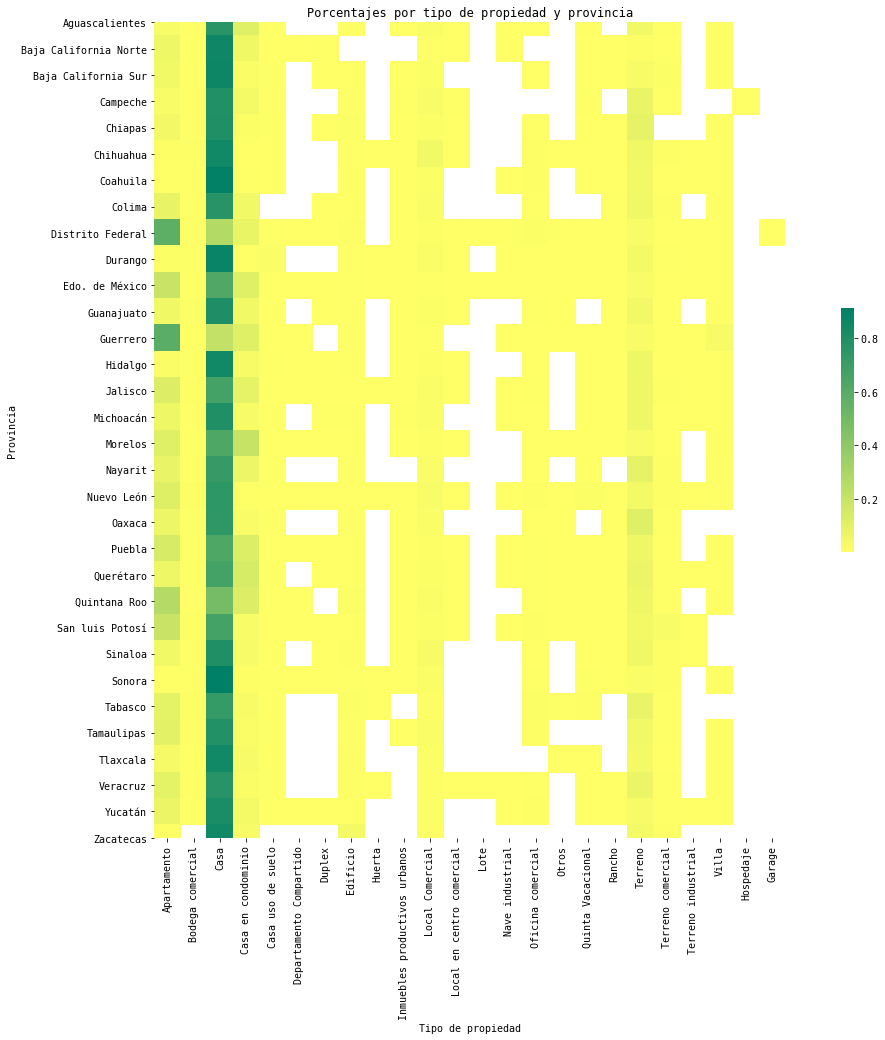

In [77]:
publicaciones_por_provincia_y_tipo_for_heatmap = publicaciones_por_provincia_y_tipo.pivot_table(index='provincia', columns='tipodepropiedad', values='porcentaje', aggfunc='sum')
get_heatmap(publicaciones_por_provincia_y_tipo_for_heatmap, xlabel="Tipo de propiedad", ylabel="Provincia", title="Porcentajes por tipo de propiedad y provincia")

#### Se puede visualizar en el heatmap que en general la cantidad de publicaciones de casas es muy grande, en relación con los demás tipos de propiedades.

## Relación entre tipo de propiedad y precio
A continuación intentaremos determinar el impacto que tiene el tipo de propiedad en el precio. Para ello nos concetraremos primero en el grupo de tipos de propiedad correspondiente a las viviendas. Este grupo tendrá los inmuebles de tipo: Apartamento, Casa, Casa en condominio, Casa uso de suelo, Departamento Compartido y Duplex.

In [78]:
# Obtenemos un df con las publicaciones de viviendas
tipo_vivienda = ['Apartamento', 'Casa', 'Casa en condominio', 'Casa uso de suelo', 'Departamento Compartido', 'Duplex']
publicaciones_viviendas = publicaciones.set_index('tipodepropiedad')
publicaciones_viviendas = publicaciones_viviendas.filter(items=tipo_vivienda, axis=0)
publicaciones_viviendas.reset_index(inplace=True)

Por ahora tomemos este df tal como está y comparemos los precios utilizando un Boxplot.

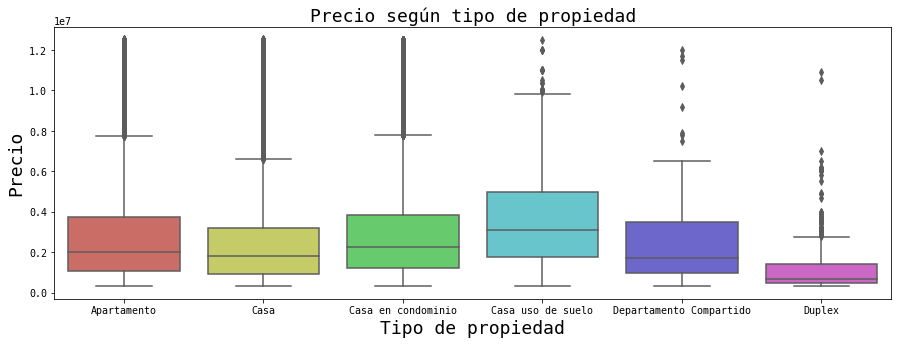

In [79]:
get_boxplot(publicaciones_viviendas, 'tipodepropiedad', 'precio', (15,5))

Tener en cuenta que la escala de precios es 1e7, por lo tanto 0.2 es 2,000,000.00.
A simple vista lso apartamentos, las casas y las casas en condominio tienen precios similares (en promedio).
El problema de este análisis es que no se tiene en cuenta que existen otros factores que podrían variar el precio, por ejemplo los metros cuadrados. Es decir si una casa y un apartamento tienen metros cuadrados similares, ¿El precio también es similar?. La zona es otro factor muy importanto, seguramente si un apartamento se encuentra en distrito federal y una casa en California del Norte los precios no serían muy similares.A continuación se comienza a hacer este análisis.

### Relación entre tipo de propiedad y precio, tienendo en cuenta otros factores
Para comenzar, vamos a considerar un factor fundamental que es la zona. Vamos a concentrarnos primero en la zona de Distrito Federal donde hay gran cantidad de departamos y casas (aunque estas últimas en menor medida).

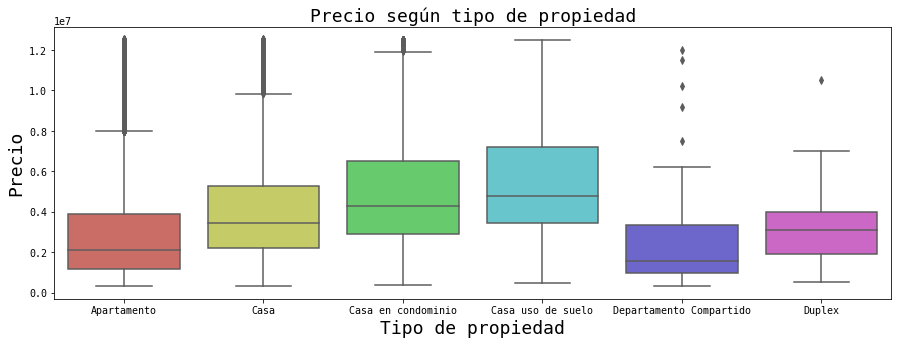

In [80]:
publicaciones_distrito_federal = publicaciones.set_index('provincia')
publicaciones_distrito_federal = publicaciones_distrito_federal.filter(items=['Distrito Federal'], axis=0)
publicaciones_distrito_federal.reset_index(inplace=True)
publicaciones_distrito_federal.set_index('tipodepropiedad', inplace=True)
publicaciones_distrito_federal = publicaciones_distrito_federal.filter(items=tipo_vivienda, axis=0)
publicaciones_distrito_federal.reset_index(inplace=True)

get_boxplot(publicaciones_distrito_federal, 'tipodepropiedad', 'precio', (15,5))

Vemos que para este caso los precios comienzan a ser bastante diferentes. Los apartamentos son más baratos que las casas. Si bien esta aproximación parece ser más realista todavía quedan otros factores que podrían estar afectando los precios, por ejemplo los metros cuadrados. En general las casas tienen más metros cuadrados que los departamentos. Si considerarámos viviendas de metros cuadrados similares, ¿Cuál será el resultado?

Primera verifiquemos que todas las propiedades tienen los valores de metros cuadrados.

In [81]:
publicaciones_distrito_federal.isnull().sum()

tipodepropiedad                   0
provincia                         0
id                                0
titulo                         1304
descripcion                     315
direccion                      5856
ciudad                           20
antiguedad                     5742
habitaciones                   1291
garages                        5799
banos                          2440
metroscubiertos                1430
metrostotales                 19727
idzona                         2828
lat                           23617
lng                           23617
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
mes                               0
ano                               0
dia                               0
dtype: int64

In [82]:
publicaciones_distrito_federal.loc[(publicaciones_distrito_federal['metroscubiertos'].isnull()) & (publicaciones_distrito_federal['metrostotales'].isnull())]

,tipodepropiedad,provincia,id,titulo,descripcion,direccion,ciudad,antiguedad,habitaciones,garages,...,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia


Como se observa hay publicaciones que no tienen los metros cuadrados cubiertos o bien no tienen los metros cuadrados totales, pero no hay ninguna que no tenga ninguno de los 2 datos. Esto podría indicar que en caso que los metros totales estén en null, significa que los metros cubiertos son los metros totales y viceversa. Para no dejar fuera del análisis estas publicaciones consideraremos que lo dicho anteriormente es cierto, por lo tanto actualizaremos los valores.

In [83]:
publicaciones_distrito_federal.loc[publicaciones_distrito_federal['metroscubiertos'].isnull(), ['metroscubiertos']] = publicaciones_distrito_federal['metrostotales']
publicaciones_distrito_federal.loc[publicaciones_distrito_federal['metrostotales'].isnull(), ['metrostotales']] = publicaciones_distrito_federal['metroscubiertos']

In [84]:
#Verificamos que no haya valores en 0
publicaciones_distrito_federal.loc[publicaciones_distrito_federal['metrostotales'] == 0]

,tipodepropiedad,provincia,id,titulo,descripcion,direccion,ciudad,antiguedad,habitaciones,garages,...,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia


Ahora que todas las propiedades tienen valores en el campo metros cuadrados es necesario determinar un rango de análisis. Análiamos con un histograma en qué rangos se encuentran aproximadamente la mayor cantidad de publicaciones.

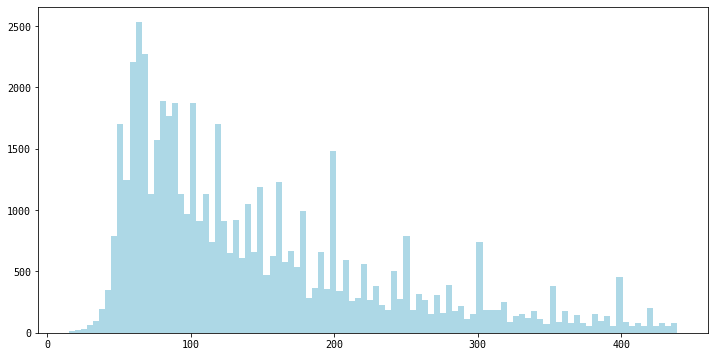

In [85]:
get_hist(publicaciones_distrito_federal["metrostotales"], bins=100)

Para que la cantidad de muestras entre los distintos tipos de propiedades sea similar vamos a tomar el rango 120 a 130

In [111]:
publicaciones_entre_120_y_130 = publicaciones_distrito_federal.loc[(publicaciones_distrito_federal["metrostotales"] >= 120) & (publicaciones_distrito_federal["metrostotales"] <= 130)]
publicaciones_entre_120_y_130.groupby("tipodepropiedad").agg({"id":"count"})

,id
tipodepropiedad,
Apartamento,2002
Casa,1030
Casa en condominio,304
Casa uso de suelo,14
Departamento Compartido,4
Duplex,4


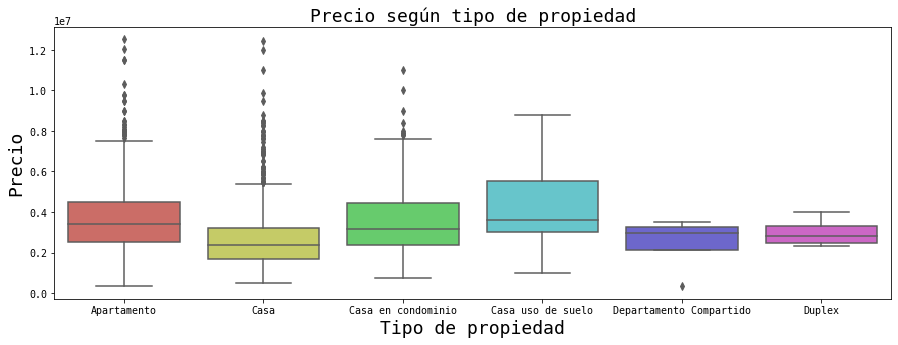

In [112]:
get_boxplot(publicaciones_entre_120_y_130, 'tipodepropiedad', 'precio', (15,5))

De este gráfico sólo podemos considerar válidos los datos de departamentos, casas y casas en condominio, dado que la cantidad de muestras de los demás tipos de propiedades no es representativo.
Si consideramos propiedades de metros similares vemos que los departamentos son más caros. Entonces por qué en el gráfico anterior mostraba que las casas son más caras que los departamentos y aquí ocurre lo contrario? Es de suponer que la casas tienen más metros cuadrados que los departamentos en general, y si consideramos que el precio se ve más afectado por la cantidad de metros cuadrados que por el tipo de propiedad es de esperarse que el gráfico anterior indique que el precio de las casas es más alto. Lo anterior se puede verificar con el siguiente gráfico.

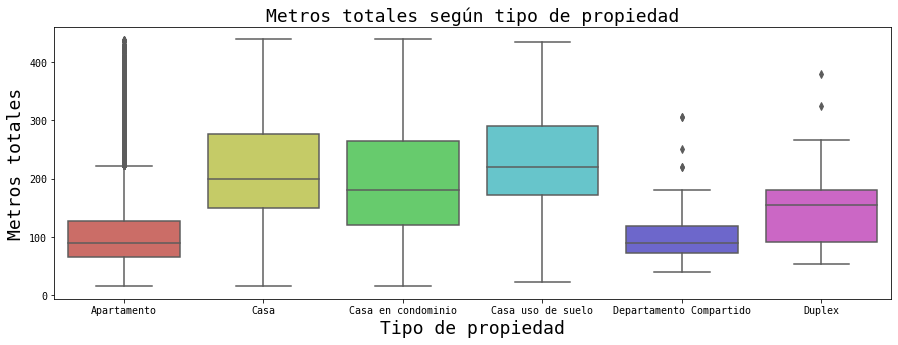

In [117]:
get_boxplot(publicaciones_distrito_federal, 'tipodepropiedad', 'metrostotales', (15,5), title="Metros totales según tipo de propiedad", label_x="Tipo de propiedad", label_y="Metros totales")